In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load brain3 data

In [3]:
# load all cells in the brain - realigned just loads faster version here
obs = abc.get_combined_metadata(realigned=True, version="20230830", drop_unused=False)
obs.columns

Index(['brain_section_label', 'cluster_alias', 'average_correlation_score',
       'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class',
       'subclass', 'supertype', 'cluster', 'x_reconstructed',
       'y_reconstructed', 'z_reconstructed', 'parcellation_index', 'x_ccf',
       'y_ccf', 'z_ccf', 'parcellation_division', 'parcellation_structure',
       'parcellation_substructure', 'slice_int', 'x_ccf_realigned',
       'y_ccf_realigned', 'z_ccf_realigned', 'parcellation_index_realigned',
       'parcellation_division_realigned', 'parcellation_structure_realigned',
       'parcellation_substructure_realigned', 'left_hemisphere',
       'left_hemisphere_realigned'],
      dtype='object')

## load CCF structures

In [4]:
realigned=False
ccf_images = abc.get_ccf_labels_image(resampled=True, realigned=realigned)
if realigned:
    ccf_label = 'parcellation_substructure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_substructure'
    coords = 'reconstructed'

## Preprocessing

### Subset to thalamus & neurons

In [5]:
# get thalamus CCF substructure names
th_names = abc.get_thalamus_substructure_names()
th_subregion_names = list(set(th_names).difference(['TH-unassigned']))

In [6]:
# remove non-neuronal and some other outlier non-thalamus types
obs_neurons = abc.filter_adata_by_class(obs, filter_midbrain=False)

In [7]:
# filter to thalamus boundaries (add a buffer here if wanted)
filter_buffer = 0  # 5
obs_th_neurons = abc.filter_by_thalamus_coords(obs_neurons, 
                                               realigned=realigned, 
                                               buffer=filter_buffer)
obs_th_strict = obs_th_neurons

### Set TH sections

In [8]:
section_col = 'z_section'
sections_all = sorted(obs_th_neurons[section_col].unique())

In [9]:
# 3 sections that representatively span the AP axis of the thalamus
sections_GRC = [6.4, 7.2]

### Precalculate CCF boundaries

In [10]:
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )
# can skip and def as none to calculate on the fly
# ccf_boundaries = None

# View CCF Structures

## View CCF w/ random color palette

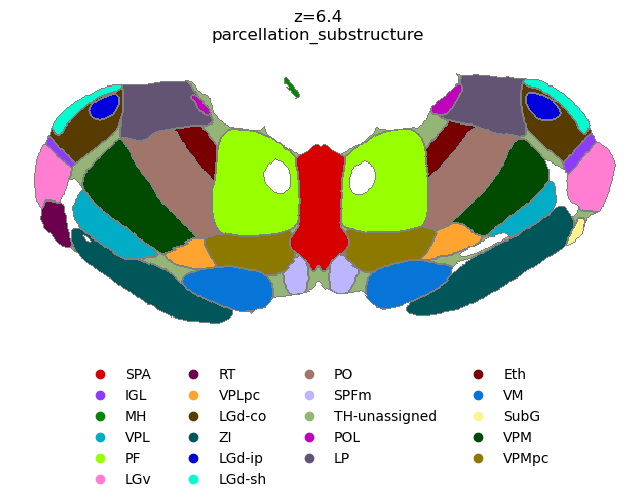

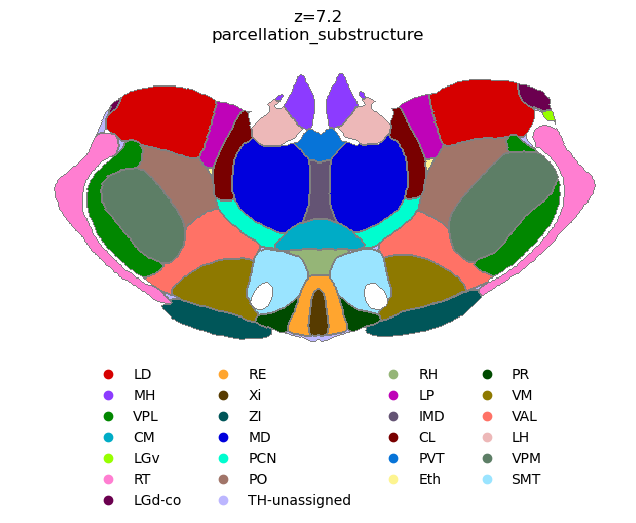

In [11]:
ara_figs = cplots.plot_ccf_overlay(obs_th_neurons.iloc[[],:], # no foreground cells; just the ccf shapes
                                    ccf_images, sections=sections_GRC, point_hue=ccf_label, 
                                    legend='ccf',
                                    face_palette='glasbey', edge_color='grey',
                                    section_col=section_col,
                                    x_col = 'x_'+coords,
                                    y_col = 'y_'+coords,
                                    min_section_count=0, 
                                    boundary_img=ccf_boundaries);

# View Cell Types + CCF Overlay

## Select thalamus celltype subsets

In [12]:
subclasses_all = obs_th_strict['subclass'].value_counts().loc[lambda x: x>100].index
print(f'{len(subclasses_all) = }')

supertypes_all = obs_th_strict['supertype'].value_counts().loc[lambda x: x>20].index
print(f'{len(supertypes_all) = }')

len(subclasses_all) = 21
len(supertypes_all) = 103


In [13]:
supertypes_from_subclasses = obs_th_neurons.loc[
    lambda df: df['subclass'].isin(subclasses_all), 'supertype'].unique()

print(f'{supertypes_from_subclasses.shape[0] = }')

print(f'{len(supertypes_all.intersection(supertypes_from_subclasses)) = }')

supertypes_from_subclasses.shape[0] = 100
len(supertypes_all.intersection(supertypes_from_subclasses)) = 94


In [14]:
clusters_from_subclasses = obs_th_neurons.loc[
            lambda df: df['subclass'].isin(subclasses_all), 'cluster'].unique()
print(f'{clusters_from_subclasses.shape[0] = }')

clusters_from_subclasses.shape[0] = 437


### Figure parameters

#### Set celltype color palettes

In [15]:
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['subclass','supertype','cluster']}

In [16]:
palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
cluster_palette = dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

#### Set plot kwargs

In [17]:
kwargs = dict(
    bg_cells=obs_th_strict,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=3, 
    face_palette=None,
    edge_color='grey',
    boundary_img=ccf_boundaries
)

#### Get obs with TH subclasses

In [18]:
obs_th_subclasses = obs_th_neurons.loc[lambda df: df['subclass'].isin(subclasses_all)]

## Subclass + CCF plots

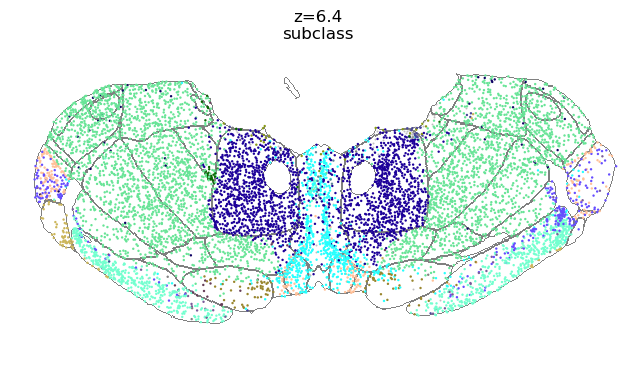

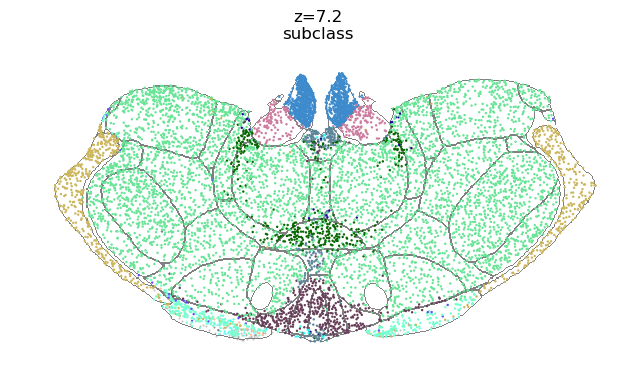

In [19]:
subclass_figs = cplots.plot_ccf_overlay(obs_th_subclasses, ccf_images, 
                                        point_hue='subclass', 
                                        sections=sections_GRC,
                                        # point_palette=abc_palettes['subclass'],
                                        legend=None, #'cells', 
                                        **kwargs)

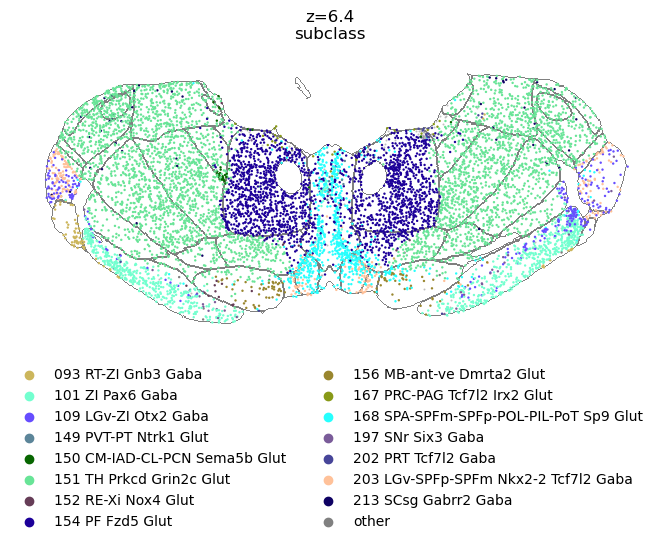

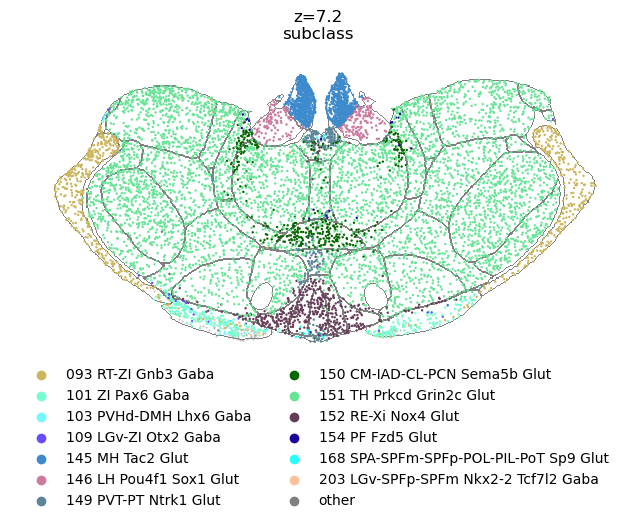

In [20]:
subclass_figs = cplots.plot_ccf_overlay(obs_th_subclasses, ccf_images, 
                                        point_hue='subclass', 
                                        sections=sections_GRC,
                                        point_palette=abc_palettes['subclass'],
                                        legend='cells', 
                                        **kwargs)

# Specific nuclei examples

## AD & AV clusters

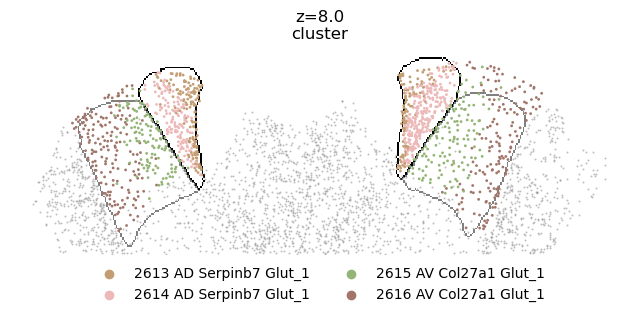

In [21]:
ant_sections = [8.0]
ad_av_nuclei = ['AD', 'AV']
ad_av_clusters = [str(x) for x in list(range(2613, 2616+1))]
ad_av_obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(ad_av_clusters)]

kwargs = dict(
    bg_cells=obs_th_strict,
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=4, 
    face_palette=None,
    edge_color='grey',
    boundary_img=ccf_boundaries
)

figs = cplots.plot_ccf_overlay(ad_av_obs, ccf_images, sections=ant_sections,
                               point_hue='cluster', point_palette=cluster_palette,
                               ccf_names=['AD', 'AV'], ccf_highlight=['AD'],
                               custom_xy_lims=[3.7,7.6, 5.9, 4.6],
                               legend='cells', **kwargs);
figs[0].savefig(f'/results/abc_ccf_AD_AV_clusters_z{int(ant_sections[0]*10)}.pdf', 
               bbox_inches='tight')

## MD

In [22]:
nucleus='MD'
md_sections = [6.8, 7.0, 7.2]
md_xy_lims = [4.3, 6.8, 6.2, 4.4]
md_kwargs = dict(
                bg_cells=obs_th_strict,
                section_col=section_col,
                x_col = 'x_'+coords,
                y_col = 'y_'+coords,
                s=10, 
                face_palette=None,
                edge_color='grey',
                boundary_img=ccf_boundaries
            )

6.8


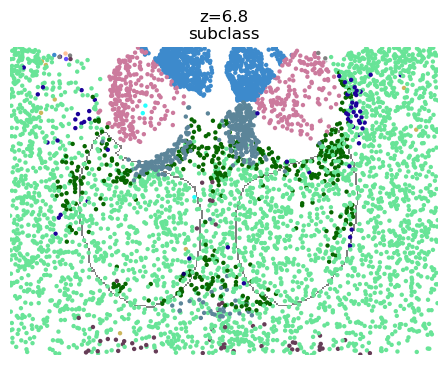

7.0


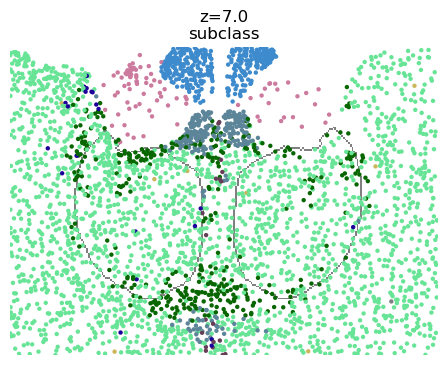

7.2


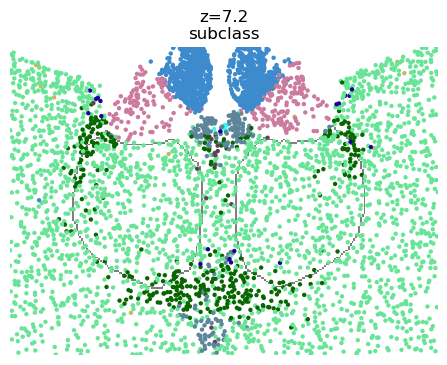

In [23]:
taxonomy_level = 'subclass'
md_figs = cplots.plot_ccf_overlay(obs_th_subclasses, 
                                  ccf_images, 
                                  sections=md_sections,
                                  point_hue=taxonomy_level, 
                                  point_palette=abc_palettes[taxonomy_level],
                                  ccf_names=[nucleus],
                                  custom_xy_lims=md_xy_lims,
                                  legend=None, 
                                  **md_kwargs);

for i, fig in enumerate(md_figs):
    sec = int(md_sections[i]*10)
    fig.savefig(f'/results/ccf_MD_{taxonomy_level}_z{sec}.pdf', transparent=True,
                bbox_inches='tight')

In [24]:
# clusters with >=1% of cells in the MD
# see metrics notebook for code
md_clusters = ['2678 TH Prkcd Grin2c Glut_10',
                 '2648 TH Prkcd Grin2c Glut_1',
                 '2635 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2681 TH Prkcd Grin2c Glut_12',
                 '2644 CM-IAD-CL-PCN Sema5b Glut_4',
                 '2682 TH Prkcd Grin2c Glut_12',
                 '2683 TH Prkcd Grin2c Glut_13',
                 '2638 CM-IAD-CL-PCN Sema5b Glut_2',
                 '2677 TH Prkcd Grin2c Glut_10',
                 '2636 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2664 TH Prkcd Grin2c Glut_6',
                 '2687 TH Prkcd Grin2c Glut_13',
                 '2636 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2664 TH Prkcd Grin2c Glut_6',
                 '2687 TH Prkcd Grin2c Glut_13',
                 '2639 CM-IAD-CL-PCN Sema5b Glut_2',
                 '2633 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2674 TH Prkcd Grin2c Glut_9',
                 '2634 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2643 CM-IAD-CL-PCN Sema5b Glut_4',
                 '2662 TH Prkcd Grin2c Glut_6',
                 '2622 PVT-PT Ntrk1 Glut_2',
                 '2621 PVT-PT Ntrk1 Glut_2',
                 '2642 CM-IAD-CL-PCN Sema5b Glut_3',
                 '2637 CM-IAD-CL-PCN Sema5b Glut_2',
                 '2663 TH Prkcd Grin2c Glut_6',
                 '2632 PVT-PT Ntrk1 Glut_6'           
                   ]
md_clusters_gc = ['2678 TH Prkcd Grin2c Glut_10',
                 '2648 TH Prkcd Grin2c Glut_1',
                 '2635 CM-IAD-CL-PCN Sema5b Glut_1',
                 '2683 TH Prkcd Grin2c Glut_13']
md_clusters_1pct = md_clusters[:13]
md_clusters_2pct = md_clusters[:8]
md_clusters_top4 = md_clusters[:4]
md_clusters_5pct = md_clusters[:3]

obs_md = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters)]
obs_md_grc = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_gc)]
obs_md_1pct = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_1pct)]
obs_md_2pct = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_2pct)]
obs_md_top4 = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_top4)]
obs_md_5pct = obs_th_neurons.loc[lambda df: df['cluster'].isin(md_clusters_5pct)]
obs_md_annot = abc.get_obs_from_annotated_clusters(nucleus, obs_th_neurons)

6.8


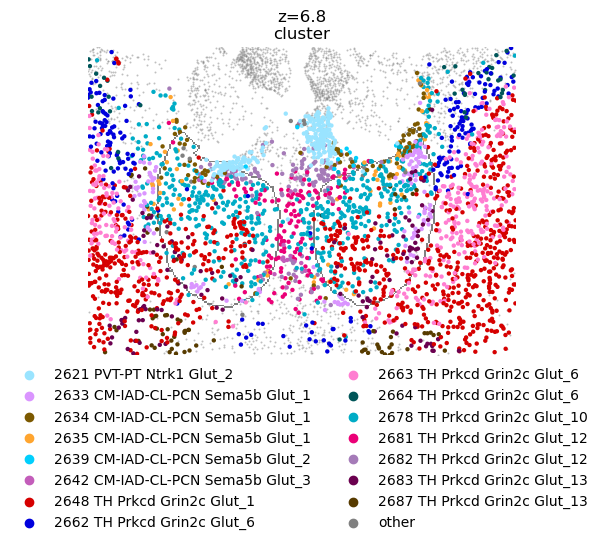

7.0


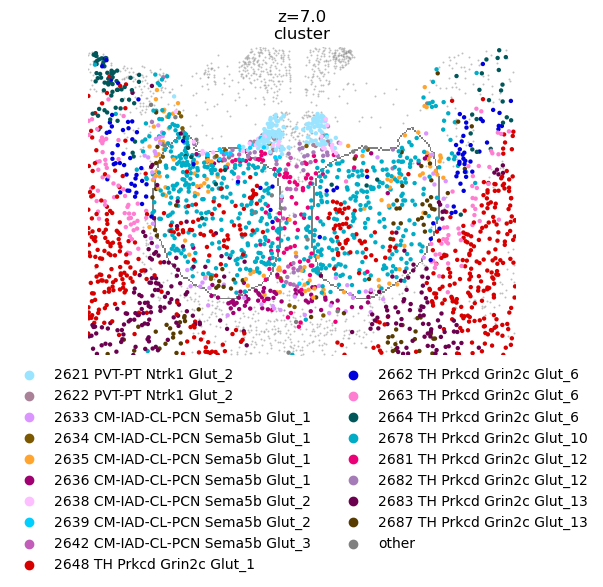

7.2


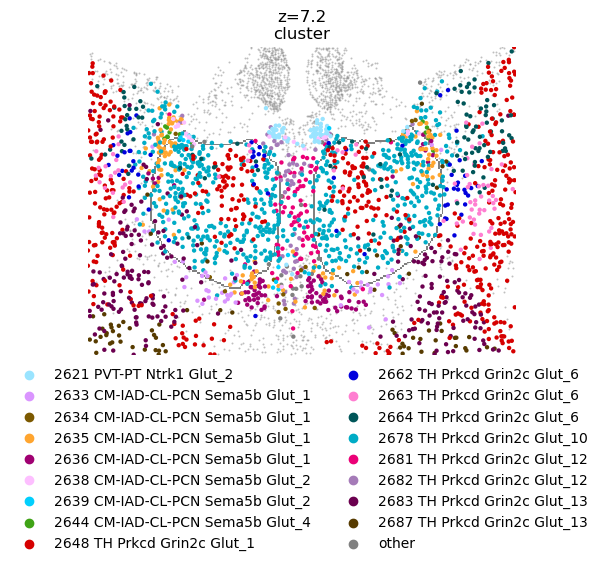

In [25]:
taxonomy_level = 'cluster'
md_figs = cplots.plot_ccf_overlay(obs_md, 
                                  ccf_images, 
                                  sections=md_sections,
                                  point_hue=taxonomy_level, 
                                  point_palette=cluster_palette,
                                  ccf_names=[nucleus],
                                  custom_xy_lims=md_xy_lims,
                                  legend='cells', 
                                  **md_kwargs);

for i, fig in enumerate(md_figs):
    sec = int(md_sections[i]*10)
    fig.savefig(f'/results/ccf_MD_{taxonomy_level}_z{sec}.pdf', transparent=True,
                bbox_inches='tight')

## Gene expression, no CCF overlay

In [26]:
adata = abc.load_adata(transform='log2', subset_to_TH_ZI=True, with_metadata=True,
                       flip_y=False, round_z=True, cirro_names=False, 
                       with_colors=True, realigned=False, loaded_metadata=None)

adata = abc.filter_adata_by_class(adata, filter_nonneuronal=True, 
                                  filter_midbrain=True, 
                                  filter_others=True)

[<Figure size 800x400 with 2 Axes>]

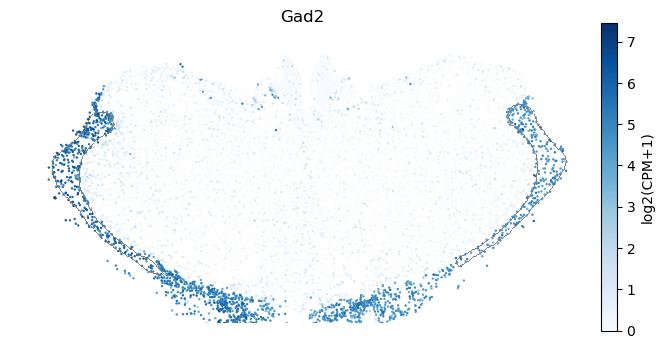

In [36]:
cplots.plot_expression_ccf(adata, 'Gad2', ccf_images, 
                           sections=[7.2], 
                           nuclei=['RT'], highlight=[],
                           s=0.5, cmap='Blues', show_outline=False, 
                           axes=False, edge_color='grey',
                           section_col='z_reconstructed', 
                           x_col='x_reconstructed',
                           y_col='y_reconstructed',
                           boundary_img=None)

[<Figure size 800x400 with 2 Axes>]

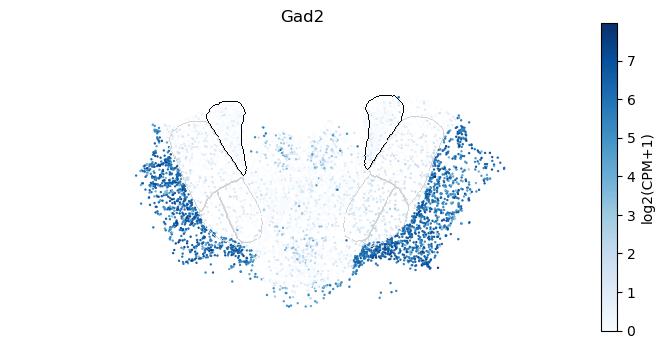

In [34]:
ant_sections = [8.0]
ant_nuclei = ['AD', 'AV', 'AM']

cplots.plot_expression_ccf(adata, 'Gad2', ccf_images, 
                           sections=ant_sections, 
                           nuclei=ant_nuclei, highlight=['AD'],
                           s=0.5, cmap='Blues', show_outline=False, 
                           axes=False, edge_color='lightgrey',
                           section_col='z_reconstructed', 
                           x_col='x_reconstructed',
                           y_col='y_reconstructed',
                           boundary_img=None)